# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

**DOUBTS**
- Calcolare alpha e beta per ogni stazione con il fit di scipy? Vanno messe due nuove colonne nel dataset? Se c'è una sola osservazione non posso fare il fit => uniforme? (alpha=1, beta=1)
- Output: AMS o alpha e beta?
- Initial guess? 
- Alpha e beta predetti per ogni stazione come vanno paragonati con quelli "veri"? Intervallo di confidenza sulla media o sui parametri (questo come si calcola) ?
- Come si fa inferenza su più distribuzioni? Quali metriche?
- 20 epoche e 2 hidden impara come 2 epoche e 0 hidden

**TO DO**
- provare con solo MAP in input
- pca?
- nel test ogni stazione ha senso che ci sia una sola volta, tanto l'output sarà sempre lo stesso


# 0. Importing libraries

In [241]:
colab = False

if colab:
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics


from fitter import Fitter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from scipy import stats   

# 1. Load and inspect the dataset

## 1.1. Load data

In [242]:
if colab:
    data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
    dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")
    dataset_indexes_test = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")
else:
    dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"
    dataset_indexes_test = "data/gumMap_statbench_Gumfit_NEW.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)

df_indexes_test = pd.read_csv(dataset_indexes_test, sep=',', encoding='utf-8') #dataset used to extract the ids for test

print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [243]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [244]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


## 1.2. Preprocess and split the dataset

In [245]:
'''def scale_AMS(df, k = 1.2):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
    """

    min_AMS = df['AMS'].min() - 1e-3 # to avoid zero values
    max_AMS = df['AMS'].max() * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df'''

'def scale_AMS(df, k = 1.2):\n    """\n        df: dataframe\n        k: Multiplication factor to extend the range of AMS values. Defaults to 1.\n    """\n\n    min_AMS = df[\'AMS\'].min() - 1e-3 # to avoid zero values\n    max_AMS = df[\'AMS\'].max() * k\n\n    df[\'AMS\'] = df.apply(lambda row: (row[\'AMS\'] - min_AMS) / (max_AMS - min_AMS), axis=1)\n\n    return df'

In [246]:
def standardize(df):
    
    features_not_to_scale = ['ID', 'AMS', 'mean_IdD', 'duration[h]']
    features_to_scale = df.columns.drop(features_not_to_scale)

    order_columns = list(features_not_to_scale) + list(features_to_scale)

    #different scalers 
    minmax_scaler = MinMaxScaler()
    robust_scaler = RobustScaler(with_centering=False)
    std_scaler = StandardScaler()
    
    scaled_data = minmax_scaler.fit_transform(df[features_to_scale])
    non_scaled_data = df[features_not_to_scale]
    std_df = np.concatenate([non_scaled_data, scaled_data], axis=1)

    # convert to dataframe
    std_df = pd.DataFrame(std_df, columns=order_columns)

    # scale AMS
    mmAMS_scaler = MinMaxScaler(feature_range=(0.001, 0.99))
    ams = std_df[['AMS']]
    scaled_ams = mmAMS_scaler.fit_transform(ams)
    std_df['AMS'] = scaled_ams

    return std_df

### Split the dataset into train, validation and test

In [247]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]

test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from std_dfs and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])
    
train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

### Standardize datasets

In [248]:
train_df_std = standardize(train_df)
val_df_std = standardize(val_df)
test_df_std = standardize(test_df)

In [249]:
# column id must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [250]:
train_df_std.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.192017,28.250,1,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
1,5001,0.106853,199.875,24,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
2,5001,0.134428,199.875,24,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
3,5001,0.148610,199.875,24,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077
4,5001,0.238819,199.875,24,0.401088,0.297265,0.34667,0.224577,0.842012,0.579848,...,0.151045,0.373266,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077


In [251]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.157177,57.052651,9.199200,0.166813,0.246883,0.322643,0.308758,0.546673,0.547496,...,0.352552,0.219492,0.314823,0.358757,0.272092,0.061749,0.309248,0.093732,0.480096,0.415496
std,4333.130131,0.059101,31.051531,8.280664,0.157116,0.200644,0.230440,0.194339,0.125339,0.156197,...,0.254254,0.149142,0.187693,0.195579,0.168673,0.128670,0.196419,0.148481,0.241816,0.233321
min,5001.000000,0.001000,5.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8094.000000,0.117288,34.984444,3.000000,0.049758,0.073997,0.104254,0.166739,0.472726,0.449271,...,0.125329,0.132894,0.168426,0.218142,0.139936,0.003447,0.150809,0.017792,0.260888,0.233598
50%,12005.000000,0.146356,49.674286,6.000000,0.120710,0.221548,0.329908,0.322565,0.546955,0.555668,...,0.340747,0.198575,0.289269,0.323356,0.232531,0.007566,0.264866,0.029456,0.517307,0.347570
75%,16065.000000,0.184222,70.343750,12.000000,0.239505,0.370564,0.483975,0.441252,0.625345,0.652737,...,0.524399,0.275427,0.435152,0.459347,0.369040,0.032635,0.433575,0.079028,0.668883,0.599175
max,20034.000000,0.990000,318.742857,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Add the guesses to datasets

In [252]:
def add_alpha_beta(df):
 
    # create two empy columns for alpha and beta
    df['alpha'] = np.nan
    df['beta'] = np.nan
 
    for id in df['ID'].unique():
       
        for duration in DURATION:
            condition = (df['ID'] == id) & (df['duration[h]'] == duration)
            ams = df[condition]['AMS']
           
            if len(ams) < 7:
                a, b = 1, 1
            else:
                a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)            
 
            df.loc[condition, 'alpha'] = a
            df.loc[condition, 'beta'] = b
 
    # if there are nan values, raise exception
    if df.isnull().values.any():
        raise Exception('There are nan values in the dataframe')
 
    return df

In [253]:
train_df_std = add_alpha_beta(train_df_std)
val_df_std = add_alpha_beta(val_df_std)
test_df_std = add_alpha_beta(test_df_std)

In [254]:
train_df_std

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
0,5001,0.192017,28.250000,1,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000,1.000000
1,5001,0.106853,199.875000,24,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000,1.000000
2,5001,0.134428,199.875000,24,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000,1.000000
3,5001,0.148610,199.875000,24,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000,1.000000
4,5001,0.238819,199.875000,24,0.401088,0.297265,0.346670,0.224577,0.842012,0.579848,...,0.504882,0.480652,0.638099,0.657211,0.658962,0.774572,0.603963,0.249077,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233213,20034,0.156730,27.678571,6,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,10.512200,57.817856
233214,20034,0.208078,19.800000,3,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,5.715366,30.606743
233215,20034,0.219212,19.800000,3,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,5.715366,30.606743
233216,20034,0.326223,12.635714,1,0.384424,0.401780,0.482421,0.531798,0.484930,0.559704,...,0.893106,1.000000,0.246884,0.254848,0.467442,0.339203,0.046453,0.706404,5.388669,30.760466


In [255]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
count,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.157177,57.052651,9.199200,0.166813,0.246883,0.322643,0.308758,0.546673,0.547496,...,0.314823,0.358757,0.272092,0.061749,0.309248,0.093732,0.480096,0.415496,7.894922,42.132528
std,4333.130131,0.059101,31.051531,8.280664,0.157116,0.200644,0.230440,0.194339,0.125339,0.156197,...,0.187693,0.195579,0.168673,0.128670,0.196419,0.148481,0.241816,0.233321,4.561008,24.680430
min,5001.000000,0.001000,5.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.670234,1.000000
25%,8094.000000,0.117288,34.984444,3.000000,0.049758,0.073997,0.104254,0.166739,0.472726,0.449271,...,0.168426,0.218142,0.139936,0.003447,0.150809,0.017792,0.260888,0.233598,5.356774,28.610409
50%,12005.000000,0.146356,49.674286,6.000000,0.120710,0.221548,0.329908,0.322565,0.546955,0.555668,...,0.289269,0.323356,0.232531,0.007566,0.264866,0.029456,0.517307,0.347570,7.038499,37.691741
75%,16065.000000,0.184222,70.343750,12.000000,0.239505,0.370564,0.483975,0.441252,0.625345,0.652737,...,0.435152,0.459347,0.369040,0.032635,0.433575,0.079028,0.668883,0.599175,9.474095,50.744758
max,20034.000000,0.990000,318.742857,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,153.461353,822.879914


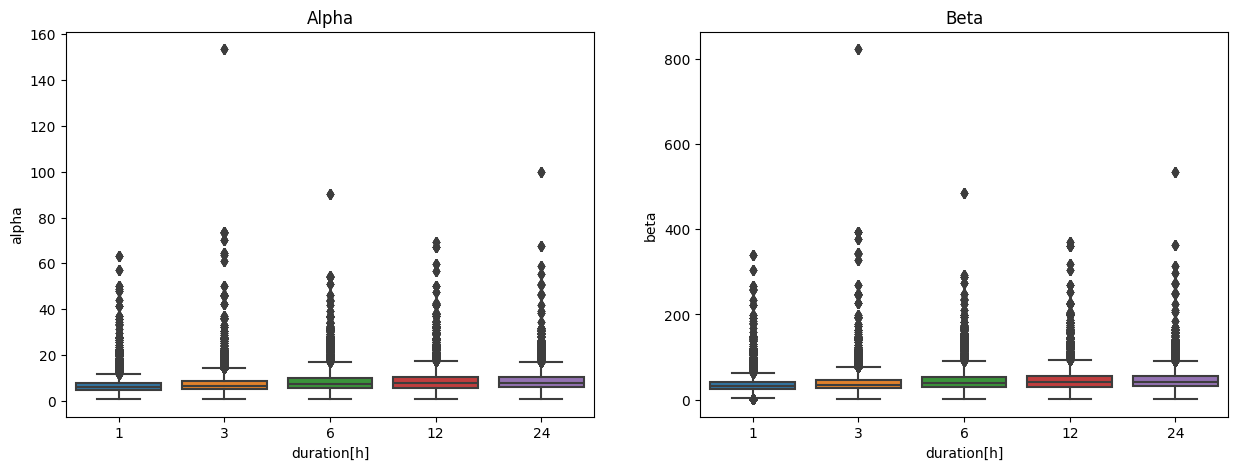

In [256]:
#boxplot of alpha and beta
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='alpha', data=train_df_std, ax=ax[0])
ax[0].set_title('Alpha')

sns.boxplot(x='duration[h]', y='beta', data=train_df_std, ax=ax[1])
ax[1].set_title('Beta')

plt.show()

In [257]:
#take the ID with the highest alpha and beta for each duration
def get_highest_alpha_beta(df, duration):
    highest_alpha = df[df['duration[h]']==duration]['alpha'].max()
    highest_beta = df[df['duration[h]']==duration]['beta'].max()
    return highest_alpha, highest_beta

for duration in DURATION:
    highest_alpha, highest_beta = get_highest_alpha_beta(train_df_std, duration)
    highest_alpha_ID = train_df_std.loc[train_df_std['alpha'] == highest_alpha, 'ID'].values[0] # [0] because the array contains the same value repeated
    highest_beta_ID = train_df_std.loc[train_df_std['beta'] == highest_beta, 'ID'].values[0]
    
    print('Duration: ', duration)
    print('Highest alpha: ', highest_alpha)
    print('Highest alpha ID: ', highest_alpha_ID)
    print('Highest beta: ', highest_beta)
    print('Highest beta ID: ', highest_beta_ID)
    ams = train_df_std[(train_df_std['ID']==highest_beta_ID)&(train_df_std['duration[h]']==duration)]['AMS']
    print('\t AMS:', ams.values)
    print('\n')

Duration:  1
Highest alpha:  63.19955523482613
Highest alpha ID:  16572
Highest beta:  338.8857904649528
Highest beta ID:  16572
	 AMS: [0.16763125 0.18431273 0.13982877 0.16095865 0.12870778 0.14761347
 0.14427717 0.14538927 0.16651915 0.18653693]


Duration:  3
Highest alpha:  153.46135324685744
Highest alpha ID:  9053
Highest beta:  822.879913636076
Highest beta ID:  9053
	 AMS: [0.1480277  0.17668108 0.14887044 0.14718495 0.15982615 0.14718495
 0.17246735]


Duration:  6
Highest alpha:  90.32709238885612
Highest alpha ID:  9084
Highest beta:  484.3791941346182
Highest beta ID:  9084
	 AMS: [0.15760675 0.17402474 0.15712386 0.13056535 0.13346264 0.1614698
 0.17643915 0.1614698  0.16243557]


Duration:  12
Highest alpha:  69.24873565338915
Highest alpha ID:  12162
Highest beta:  371.36144247640834
Highest beta ID:  12162
	 AMS: [0.15844346 0.13149555 0.16363256 0.16812879 0.17744558 0.12722044
 0.1655195  0.16553425]


Duration:  24
Highest alpha:  99.7790517924759
Highest alpha ID: 

In [258]:
AMS_count = train_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['alpha'] = train_df_std.groupby(['ID','duration[h]'])['alpha'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['beta'] = train_df_std.groupby(['ID','duration[h]'])['beta'].mean()

AMS_count.head(15)

count     alpha       beta
ID   duration[h]                            
5001 1                2  1.000000   1.000000
     3                4  1.000000   1.000000
     6                4  1.000000   1.000000
     12               4  1.000000   1.000000
     24               4  1.000000   1.000000
5002 1               23  5.783676  30.915517
     3               23  3.319800  17.445358
     6               23  3.585096  19.013652
     12              23  4.753417  25.449980
     24              23  4.118149  22.052723
5003 1               55  5.088735  27.305118
     3               56  3.281494  17.708765
     6               56  3.248882  17.550986
     12              56  3.418482  18.491488
     24              56  3.378320  18.301035

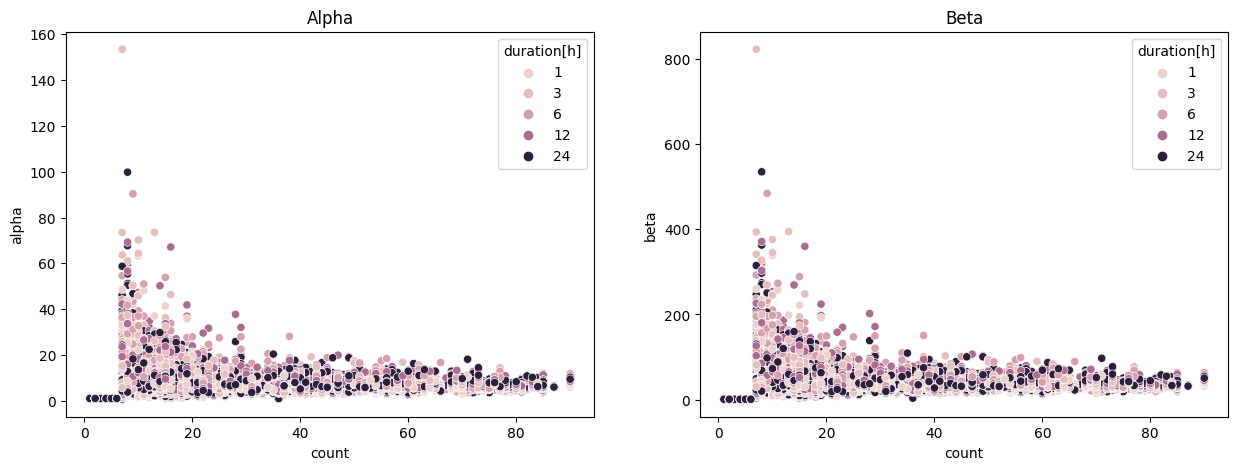

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='alpha', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Alpha')

sns.scatterplot(x='count', y='beta', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Beta')

plt.show()

## 1.4. Prepare data for training

In [260]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y', 'alpha', 'beta'],
      dtype='object')

In [261]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns = train_df_std.columns [3:-2] 
output_column = 'AMS'
parameters_columns = ['ID','duration[h]','alpha', 'beta']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [262]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

# 2. Model definition

#### Base model

In [263]:
def build_nn_beta_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)

    alpha_beta = layers.Dense(2, activation='exponential')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,0:1], concentration1=t[:,1:2], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

# 3. Metrics 

In [280]:
def sample_metrics(dist, y, label, color, plot = True):
    num_samples = 1
    y_pred = dist.sample(num_samples).numpy().ravel()
    
    mae = metrics.mean_absolute_error(y, y_pred)
    ks_statistics, _ = stats.ks_2samp(y, y_pred)

    if plot:
        plt.hist(y, bins='auto', alpha=0.7, label=label, density=True, color='green');
        #sns.kdeplot(y_pred, label='Estimated sample', fill=True)
        plt.hist(y_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color=color);
        plt.legend()
        plt.show()

    return mae, ks_statistics

def plot_series(data, labels=None, predictions=None, figsize=None, filled_version=None, std=None, ci=None, title=None, ylim=None):
    
    plt.figure(figsize=figsize)
    plt.plot(data.index, data.values, zorder=0)
    
    if filled_version is not None:
        filled = filled_version.copy()
        filled[~data['value'].isnull()] = np.nan
        plt.scatter(filled.index, filled, marker='.', c='tab:orange', s=5);
    
    # Plot standard deviations
    if std is not None:
        lb = data.values.ravel() - std.values.ravel()
        ub = data.values.ravel() + std.values.ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='+/- std')
    
    # Plot confidence intervals
    if ci is not None:
        lb = ci[0].ravel()
        ub = ci[1].ravel()
        plt.fill_between(data.index, lb, ub, alpha=0.3, label='C.I.')
    
    # Rotated x ticks
    plt.xticks(rotation=45)
    
    # Plot labels
    if labels is not None:
        plt.scatter(labels.values, data.loc[labels], color='red', zorder=2, s=5)
    
    # Predictions
    if predictions is not None:
        plt.scatter(predictions.values, data.loc[predictions], color='black', alpha=.4, zorder=3, s=5)
    
    # Force y limits
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.grid(linestyle=':')
    plt.title(title)
    plt.tight_layout()

def percentage_in_ci(inputs, y, dist, confidence, distribution = 'beta', start = None, end = None, plot = True, num_samples=1):
    
    if start is None:
        start = 0
    if end is None:
        end = len(y)

    if distribution == 'beta':
        lb, ub = stats.beta.interval(confidence, a=dist.concentration1, b=dist.concentration0)
        mean_dist = dist.mean().numpy().ravel()
        y_pred = dist.sample(num_samples).numpy().ravel()

        if plot:
            plot_series(pd.Series(index=inputs[start:end].index, data=mean_dist[start:end]), ci=(lb[start:end], ub[start:end]), figsize=(12,6))
            plt.scatter(inputs[start:end].index, y_pred[start:end], marker='o', color='blue', label='Predicted');
            plt.scatter(inputs[start:end].index, y[start:end], marker='x', color='red', label='True');
            plt.legend()
            plt.show()
    
        count_true = 0
        for i in range(len(y)):
            if lb[i] <= y[i] <= ub[i]:
                count_true += 1
        
        true_guess = count_true/len(y)*100

        return true_guess
    
def parameters_metrics(dist, true_parameters, plot=True, calculate_metrics = True, remove_outliers = False):

    a_pred = dist.concentration1.numpy().ravel()
    a_true = true_parameters['alpha'].to_numpy()
    a_max = a_pred.max() + 10

    b_pred = dist.concentration0.numpy().ravel()
    b_true = true_parameters['beta'].to_numpy()
    b_max = b_pred.max() + 10
    
    parameters = true_parameters.copy()
    parameters['alpha_pred'] = a_pred
    parameters['beta_pred'] = b_pred

    if remove_outliers:
        out_indexes = np.where(a_true > 500)
        a_pred = np.delete(a_pred, out_indexes)
        a_true = np.delete(a_true, out_indexes)

        out_indexes = np.where(b_true > 1500)
        b_pred = np.delete(b_pred, out_indexes)
        b_true = np.delete(b_true, out_indexes)


    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        sns.scatterplot(x='alpha_pred', y='alpha', data=parameters, hue='duration[h]', ax=ax[0], marker='o')
        x = np.linspace(0, a_max, 100)
        ax[0].plot(x, x, color='black', linestyle='--')
        ax[0].set_xlabel('Predicted alpha')
        ax[0].set_ylabel('True alpha')
        ax[0].set_title('Scatter plot of the predicted alpha values')
        
        sns.scatterplot(x='beta_pred', y='beta', data=parameters, hue='duration[h]', ax=ax[1], marker='o')
        x = np.linspace(0, b_max, 100)
        ax[1].plot(x, x, color='black', linestyle='--')
        ax[1].set_xlabel('Predicted beta')
        ax[1].set_ylabel('True beta')
        ax[1].set_title('Scatter plot of the predicted beta values')
        plt.show()

    if calculate_metrics:
        alpha_biasr = ((a_true - a_pred) / a_true).mean()
        alpha_rmse = metrics.root_mean_squared_error(a_true, a_pred)
        alpha_pcc = np.corrcoef(a_true, a_pred)[0, 1]

        beta_biasr = ((b_true - b_pred) / b_true).mean()
        beta_rmse = metrics.root_mean_squared_error(b_true, b_pred)
        beta_pcc = np.corrcoef(b_true, b_pred)[0, 1]

        return (alpha_biasr, alpha_rmse, alpha_pcc), (beta_biasr, beta_rmse, beta_pcc)

    return None

# 4. Training

In [266]:
def train_nn_model(model, X, y, batch_size, loss, lr, epochs, verbose=0, patience=30, validation_data=None, **fit_params):
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)
    
    # Build the early stop callback
    cb = []
    if validation_data is not None:
        cb += [callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, mode='auto', min_delta=1e-3)]
        
    # Train the model
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, callbacks=cb, validation_data=validation_data, verbose=verbose, **fit_params)
  
    return history

def plot_training_history(history=None, figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

## Training

In [267]:
X_train = inputs_train.values
y_train  = outputs_train.values
X_val = inputs_val.values
y_val = outputs_val.values
X_test = inputs_test.values
y_test = outputs_test.values

Epoch 1/90
456/456 [==============================] - 3s 4ms/step - loss: -1.4279 - val_loss: -0.8859
Epoch 2/90
456/456 [==============================] - 1s 3ms/step - loss: -1.4895 - val_loss: -0.6286
Epoch 3/90
456/456 [==============================] - 1s 2ms/step - loss: -1.4970 - val_loss: -0.4969
Epoch 4/90
456/456 [==============================] - 1s 3ms/step - loss: -1.4966 - val_loss: -0.8953
Epoch 5/90
456/456 [==============================] - 1s 3ms/step - loss: -1.5010 - val_loss: -0.7212
Epoch 6/90
456/456 [==============================] - 1s 3ms/step - loss: -1.5016 - val_loss: -0.7326
Epoch 7/90
456/456 [==============================] - 1s 3ms/step - loss: -1.5026 - val_loss: -0.6186
Epoch 8/90
456/456 [==============================] - 1s 2ms/step - loss: -1.5040 - val_loss: -1.0954
Epoch 9/90
456/456 [==============================] - 1s 3ms/step - loss: -1.5033 - val_loss: -0.7964
Epoch 10/90
456/456 [==============================] - 1s 2ms/step - loss: -1.5060

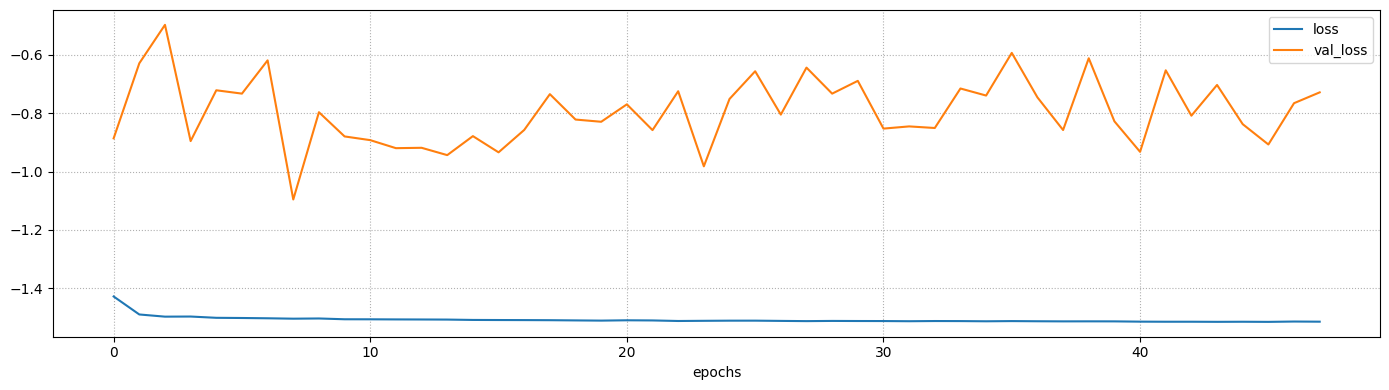

Final loss: -1.5142 (training), -0.7283 (validation)


In [268]:
# Parameters for the training
batch_size = 512 #256
epochs = 90 #30
lr = 1e-3
patience = 40 #15
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

model = build_nn_beta_model(input_shape=(X_train.shape[1],), hidden=[128,256]) #[512,64]
history = train_nn_model(model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
plot_training_history(history, figsize=(14, 4))

# Evaluation

* Train evaluation

Evaluating the models on training set...


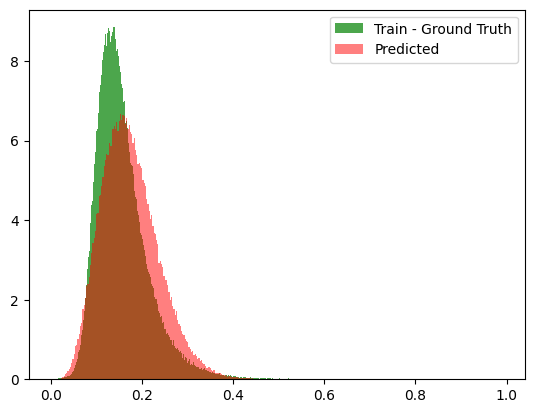

Train:
MAE: 0.07
KS statistics: 0.16


In [269]:
print('Evaluating the models on training set...')

dist_train = model(X_train)
mae_train, ks_statist_train = sample_metrics(dist_train, y_train, 'Train - Ground Truth', 'red')
print('Train:')
print(f'MAE: {mae_train:.2f}')
print(f'KS statistics: {ks_statist_train:.2f}')

# Store the results in a dataframe
results = pd.DataFrame(columns=['Split', 'MAE', 'KS statistics'])

train_no_guess = ['Train', mae_train, ks_statist_train]
results.loc[0] = train_no_guess

* Validation evaluation

Evaluating the models on validation set...


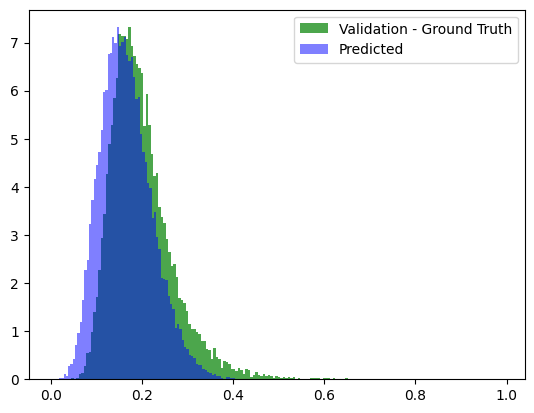

Validation:
MAE: 0.07
KS statistics: 0.19


In [270]:
print('Evaluating the models on validation set...')

dist_val = model(X_val)
mae_val, ks_statist_val = sample_metrics(dist_val, y_val, 'Validation - Ground Truth', 'blue')
print('Validation:')
print(f'MAE: {mae_val:.2f}')
print(f'KS statistics: {ks_statist_val:.2f}')

val_no_guess = ['Validation', mae_val, ks_statist_val]
results.loc[1] = val_no_guess

* Test evaluation

Evaluating the models on test set...


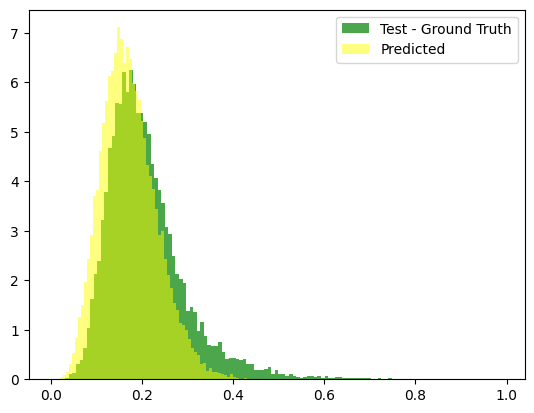

Test:
MAE: 0.08
KS statistics: 0.16


In [271]:
print('Evaluating the models on test set...')

dist_test = model(X_test)
mae_test, ks_statist_test = sample_metrics(dist_test, y_test, 'Test - Ground Truth', 'yellow')
print('Test:')
print(f'MAE: {mae_test:.2f}')
print(f'KS statistics: {ks_statist_test:.2f}')

test_no_guess = ['Test', mae_test, ks_statist_test]
results.loc[2] = test_no_guess

In [272]:
display(results)

,Split,MAE,KS statistics
0,Train,0.067673,0.156948
1,Validation,0.073239,0.187466
2,Test,0.082878,0.162569


* Distribution mean - confidence interval 

Evaluation based on confidence intervals..


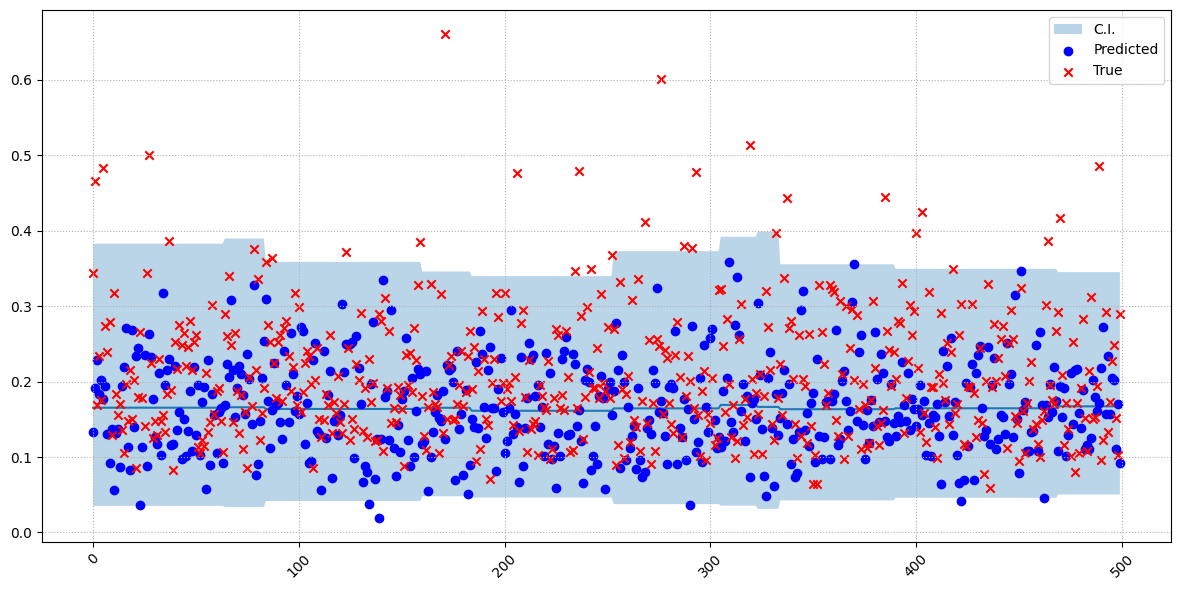

Percentage of values inside the 99% confidence interval: 93.31%


In [273]:
confidence = 0.99

print('Evaluation based on confidence intervals..')

inside = percentage_in_ci(inputs_test, y_test, dist_test, confidence, end = 500)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

# Parameters

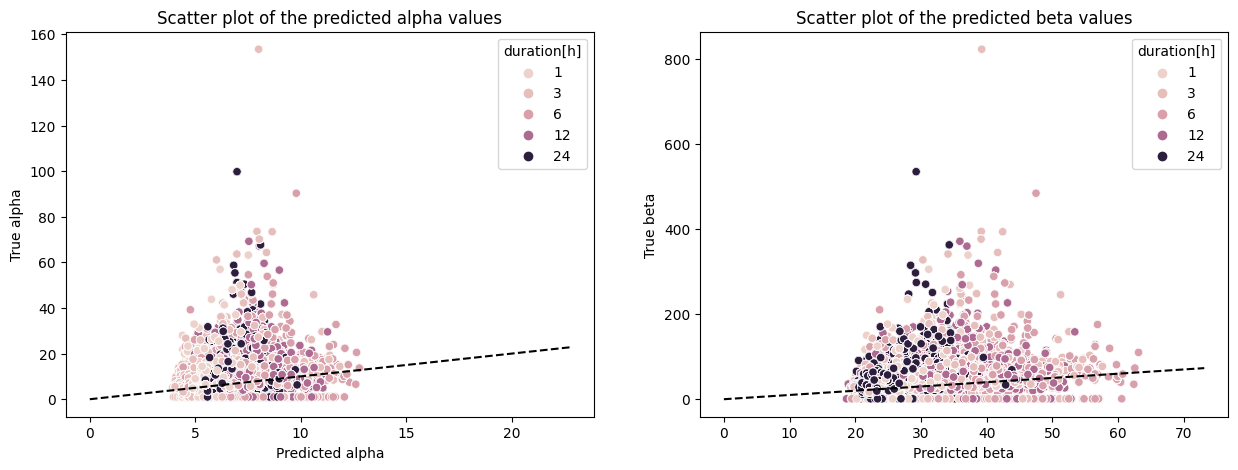

In [274]:
_ = parameters_metrics(dist_train, parameters_train, calculate_metrics = False)

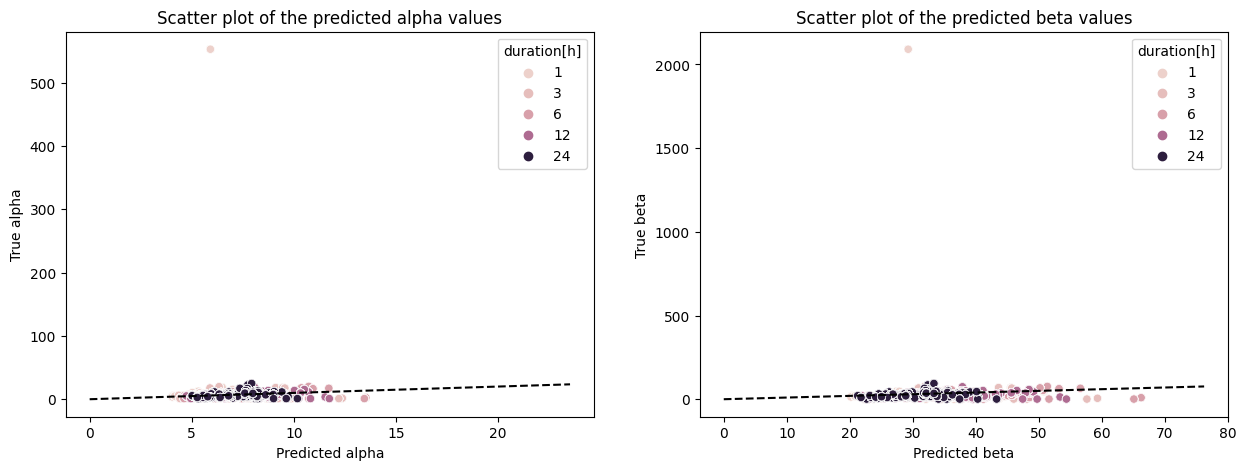

===============ALPHA PARAMETER===============
Biasr: -0.41
RMSE: 2.89
PCC: 0.37
===============BETA PARAMETER===============
Biasr: -1.12
RMSE: 15.09
PCC: 0.32


In [281]:
(alpha_biasr, alpha_rmse, alpha_pcc), (beta_biasr, beta_rmse, beta_pcc) = parameters_metrics(dist_test, parameters_test, remove_outliers = True)

print('===============ALPHA PARAMETER===============')
print(f'Biasr: {alpha_biasr:.2f}')
print(f'RMSE: {alpha_rmse:.2f}')
print(f'PCC: {alpha_pcc:.2f}')

print('===============BETA PARAMETER===============')
print(f'Biasr: {beta_biasr:.2f}')
print(f'RMSE: {beta_rmse:.2f}')
print(f'PCC: {beta_pcc:.2f}')

* Comparison between two samples extracted from "true" and predicted distribution of the same place 

True alpha:  4.118148612947944 Predicted alpha:  5.98444
True beta:  22.052722654917535 Predicted beta:  30.677168


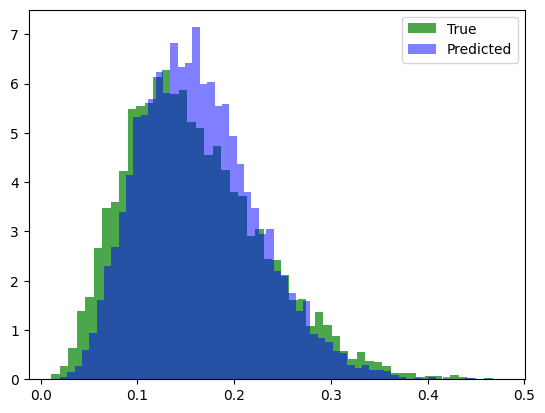

In [ ]:
index = 30

a_pred = dist_train.concentration1.numpy().ravel()[index]
b_pred = dist_train.concentration0.numpy().ravel()[index]

a_true = parameters_train['alpha'][index]
b_true = parameters_train['beta'][index]

print('True alpha: ', a_true, 'Predicted alpha: ', a_pred)
print('True beta: ', b_true, 'Predicted beta: ', b_pred)

samples_pred = stats.beta.rvs(a=a_pred, b=b_pred, size=10000)
samples_true = stats.beta.rvs(a=a_true, b=b_true, size=10000)

plt.hist(samples_true, bins='auto', alpha=0.7, label='True', density=True, color='green');
plt.hist(samples_pred, bins='auto', alpha=0.5, label='Predicted', density=True, color='blue');
plt.legend()
plt.show()